In [1]:
import os, sys

sys.path.insert(0, os.path.abspath('..'))
os.environ['USE_PYGEOS'] = '0'

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import geemap, ee
import pandas as pd
from shapely.geometry import shape
from shapely.geometry import Polygon
import uuid
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from babelgrid import Babel

from google.cloud import storage
from google.oauth2 import service_account
import json

import gc
gc.enable()

from rasterio.plot import show
import rasterio
from rasterio.merge import merge
from rasterio.transform import from_origin
from rasterio.enums import Resampling

import glob

In [3]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [116]:
gcp_cred_file = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
with open(gcp_cred_file) as source:
    info = json.load(source)

storage_credentials = service_account.Credentials.from_service_account_info(info)


project_id = 'gee-sand'

storage_client = storage.Client(project=project_id, credentials=storage_credentials)

In [119]:
from utils import gcp_utils

In [5]:
def generate_fishnet(polygon, x, y, crs = 'EPSG:4326'):
    ##To do: add padding
    print("Generating Fishnet!", datetime.now())
    # Get the bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate arrays of x and y coordinates for the fishnet
    x_coords = np.arange(minx, maxx + x, x)
    y_coords = np.arange(miny, maxy + y, y)


    cells = []

    # Create grid cells
    for i in range(len(x_coords) - 1):
        for j in range(len(y_coords) - 1):
            cell = Polygon([
                (x_coords[i], y_coords[j]),
                (x_coords[i + 1], y_coords[j]),
                (x_coords[i + 1], y_coords[j + 1]),
                (x_coords[i], y_coords[j + 1]),
            ])
            # If the cell intersects with the polygon add to list of cells
            if cell.intersects(polygon):
                cells.append(cell)

    # Create a GeoDataFrame with the grid cells
    fishnet = gpd.GeoDataFrame(geometry=cells, crs=crs)
    print("Complete!", datetime.now())
    return fishnet


def optimal_smooth_fishnet(fishnet_grid, 
                          min_length, 
                          min_height, 
                          max_area):
    """
    Given a Fishnet grid, combine cells to generate a new polygon (square or rectangle), such that 
    polygon has 
    1) length at least MIN_LENGTH
    2) height at least MIN_HEIGHT
    3) area at most MAX_AREA
    
    """
    print("Merging!", datetime.now())
    
    #Create some variables
    cells = []
    polygons = []
    
    add_geom = True
    last_polygon= None
    cell_add = True
    
    geoms = fishnet_grid.geometry.values

    new_minx, new_miny, _, _ =  fishnet_grid.total_bounds #Don't need this, delete

    #### Starting with the left most cell, grow a polygon. 
    ### 
    for geom in geoms:
        
        geom_centroid = geom.centroid
        geom_minx, geom_miny, geom_maxx, geom_maxy = geom.bounds
        
        ##This snippet below is my current hack to prevent overlaps. 
        ### Overlaps can still occur in portions where the river meanders a lot. 
        
        if (last_polygon is not None) & (geom_centroid.within(last_polygon)):
            cell_add = False
        else:
            cell_add = True

        if len(cells) > 0:

            ### keep checking the area of the grown polygon if the current list of cells is not empty
            tmp = gpd.GeoDataFrame(geometry = cells)
            minx, miny, maxx, maxy = tmp.total_bounds

            l = (maxx - minx)
            w = (maxy - miny)
            area =  l * w

            
            if (area > max_area) & (l > min_length) & ( w > min_height):
                polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
                polygons.append(polygon)
                last_polygon  = polygon
                new_minx = maxx
                new_miny = maxy
                add_geom = False
                cells = []

        if (add_geom) & (cell_add):
            cells.append(geom)

        if len(cells) == 0:
            add_geom = True
            
    print("Complete!", datetime.now())
    return polygons


def toDb(image):
    """
    Converts S1 image to decibel scale
    """
    return image.addBands(
    ee.Image().expression('10 * log10(linear)', {
      'linear': image.select(['VV', 'VH'])
      }),None, True); # Replace the bands to keep image properties

def dbNorm(image):
    """
    Normalizes an S1 image
    """
    return ee.Image(image.divide(30.0).add(1.0))

def getCover(image, aoi, scale):

    # calculate the number of inputs
    totPixels = ee.Number(image.unmask(1).reduceRegion(**{
      'reducer': ee.Reducer.count(),
      'scale': scale,
      'geometry': aoi,
    }).values().get(0))

    # Calculate the actual amount of pixels inside the aoi
    actPixels = ee.Number(image.reduceRegion(**{
      'reducer': ee.Reducer.count(),
      'scale': scale,
      'geometry': aoi,
    }).values().get(0))

    # calculate the perc of cover
    percCover = actPixels.divide(totPixels).multiply(100).round()
    percCover = percCover.getInfo()
    return percCover

def get_s1_median(year, month, aoi, clip = True):
    """
    Get median composite S1 image (in dB), for a given area, year and month. 
    
    """
    img = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')\
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filterBounds(aoi)\
        .filter(ee.Filter.calendarRange(int(year), int(year), 'year'))\
        .filter(ee.Filter.calendarRange(int(month), int(month), 'month'))\
        .median()
    
    if clip:
        img = img.clip(aoi)
    
    img = toDb(img)

    img = img.set({'month': ee.Date.fromYMD(int(year), int(month), 1)})
    
    return img

def get_s2_median(year, month, aoi, clip = True, collection = "S2_SR_HARMONIZED"):
    """
    Get median composite S2, for a given area, year and month. 
    """
    img = ee.ImageCollection(f"COPERNICUS/{collection}")\
        .filterBounds(ee.FeatureCollection(aoi).geometry().centroid(**{'maxError': 1}).buffer(display_buffer))\
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
        .filter(ee.Filter.calendarRange(int(year), int(year), 'year'))\
        .filter(ee.Filter.calendarRange(int(month), int(month), 'month'))\
        .median()
        
    img = img.set({'month': ee.Date.fromYMD(int(year), int(month), 1)})
    if clip:
        img = img.clip(aoi)
    
    return img


In [104]:
#### Load files
# df_grids = gpd.read_file("/data/sand_mining/grids/india_005.shp")

sone = gpd.read_file("/data/sand_mining/rivers/sone_polygon.geojson")

sone_grids = gpd.sjoin(df_grids, sone[:1], predicate = 'intersects')
sone_grids['leftmost_x'] = sone_grids['geometry'].apply(lambda geom: geom.exterior.xy[0][0])

sone_grids = sone_grids.sort_values('leftmost_x')
polygons = optimal_smooth_fishnet(sone_grids, 0.15, 0.15, 0.01)

df_sone = gpd.GeoDataFrame(geometry = polygons)
df_sone.crs = 'EPSG:4326'

Merging! 2023-12-18 18:03:19.187745
Complete! 2023-12-18 18:03:19.316029


/home/suraj.nair/.conda/envs/rv-21/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [105]:
df_tiles = gpd.sjoin(df_grids, df_sone)

In [169]:
cloud_files = gcp_utils.list_files_in_folder(client = storage_client, 
                          folder_name = 'S2',
                          bucket_name = 'sand_mining_grids'
                 )

cloud_files = [f.name.split("/")[1] for f in cloud_files]

cloud_files = [f for f in cloud_files if 'l1c' not in f]

processed_ids = [int(f.split("_")[0]) for f in cloud_files]

ids_to_process = [idval for idval in df_tiles['id'].unique() if idval not in processed_ids]

len(processed_ids), len(df_tiles['id'].unique()), len(ids_to_process)

(115, 316, 201)

In [170]:
display_buffer = 50000
aoi_min = 10000

s1_bands = ['VV', 'VH']
s2_bands_rgb = ['B4', 'B3' , 'B2']
s2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
s2_l1c_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']


In [171]:
year = 2022
month = 10

year = int(year)
month = int(month)
if month <10:
    mstub = '0'+str(month)
else:
    mstub = str(month)
    
    
print(year, month, mstub)

2022 10 10


In [172]:
task_dict = {}
no_export = []

print('Started', datetime.now())
for idval in ids_to_process:
    
    stub = str(idval)
    tmp = df_grids[df_grids['id'] == idval]
#     tmp = tmp.drop(columns = ['geojson'])
    
    aoi1 = geemap.geopandas_to_ee(tmp[['geometry']])
    
    s1_img = get_s1_median(YEAR, MONTH, aoi1.geometry())
    s2_img = get_s2_median(YEAR, MONTH, aoi1.geometry(), collection = 'S2_SR_HARMONIZED')
    s2_l1c_img = get_s2_median(YEAR, MONTH, aoi1.geometry(), collection = 'S2')
    
    
    ### Added logic to export images iff both s1 and s2 images have data. 
    try:
        ##Easiest way to check -- if VV and VH bands are not available, the line below will trigger an error. 
        l1 = s1_img.bandNames().length().getInfo()
    except:
        l1 = 0

    try:
        l2 = s2_img.bandNames().length().getInfo()
    except:
        l2 = 0

    if (l1 >0) & (l2 >0):
        percCover_s1 = getCover(s1_img, aoi1.geometry(), 100)
        percCover_s2 = getCover(s2_img, aoi1.geometry(), 100)

        if (percCover_s1 == 100) & (percCover_s2 == 100):
            task_s1 = ee.batch.Export.image.toCloudStorage(
                                            image = s1_img.select(s1_bands),
                                            description = stub + "_" + str(year) + "_" + mstub + '_s1',
                                            bucket = 'sand_mining_grids',
                                            fileNamePrefix=  'S1/' + stub + "_" + str(year) + "-" + mstub + "-01"  + "_s1",
                                            region = aoi1.geometry(),
                                            scale = 10,
                                            crs = 'EPSG:4326', 
                                            maxPixels = 1e13
                                            )

            task_s2_bs = ee.batch.Export.image.toCloudStorage(
                            image = s2_img.select(s2_bands),
                            description = stub + "_" + str(year) + "_" + str(month) + '_s2',
                            bucket = 'sand_mining_grids',
                            fileNamePrefix=  'S2/' +  stub + "_" + str(year) + "-" + mstub + "-01" + "_s2",
                            region = aoi1.geometry(),
                            scale = 10,
                            crs = 'EPSG:4326', 
                            maxPixels = 1e13
                            )

            task_s2_l1c_bs = ee.batch.Export.image.toCloudStorage(
                            image = s2_l1c_img.select(s2_l1c_bands),
                            description = stub + "_" + str(year) + "_" + str(month) + '_s2_l1c',
                            bucket = 'sand_mining_grids',
                            fileNamePrefix=  'S2_L1C/' + stub + "_" + str(year) + "-" + mstub + "-01" + "_s2_l1c",
                            region = aoi1.geometry(),
                            scale = 10,
                            crs = 'EPSG:4326', 
                            maxPixels = 1e13
                            )

            task_s1.start()
            task_dict[f'{stub}_{year}_{month}_s1'] = task_s1
            task_s2_bs.start()
            task_dict[f'{stub}_{year}_{month}_s2_bs'] = task_s2_bs
            task_s2_l1c_bs.start()
            task_dict[f'{stub}_{year}_{month}_s2_l1c_bs'] = task_s2_l1c_bs
            
        else:
            no_export.append(stub)
            
    else:
        no_export.append(stub)

            
print('Completed', datetime.now())          

Started 2023-12-18 18:18:33.191471
Completed 2023-12-18 18:26:03.341165


In [ ]:
### Get the grids by box. 

In [178]:
# df_sone = df_sone.reset_index()
# df_sone = df_sone.rename(columns = {'index':'id'})
# df_sone['river'] = 'Sone'

In [199]:
# Input Google Cloud Storage bucket URL
gcs_url = "https://storage.googleapis.com/sand_mining_grids/S2"

for idval in df_tiles['index_right'].unique():
    print("*********************")
    print(idval, datetime.now())
#     chunk = df_sone[df_sone['id'] == idval]
    small_chunk_ids = df_tiles[df_tiles['index_right'] == idval]['id'].unique()
    
    # Output merged raster file
    output_file = f"/data/sand_mining/predictions/raw/Sone_{idval}.tif"

    # Get a list of all raster files in the GCS bucket
    gcs_files = [f"{gcs_url}/{tile_id}_2022-10-01_s2.tif" for tile_id in small_chunk_ids]
    

    with rasterio.Env():
        print("Reading Files", datetime.now())
        src_files_to_mosaic = [rasterio.open(gcs_file) for gcs_file in gcs_files]

        print("Making Mosaic", datetime.now())
        mosaic, out_trans = merge(src_files_to_mosaic)

        print("Writing", datetime.now())
        # Create a new raster file for the merged result
        with rasterio.open(output_file, 'w', 
                           driver='GTiff', 
                           height=mosaic.shape[1], 
                           width=mosaic.shape[2], 
                           count=12,
                           dtype=mosaic.dtype, 
                           crs=src_files_to_mosaic[0].crs, 
                           transform=out_trans) as dest:
            dest.write(mosaic)

        print("Complete", datetime.now())

*********************
0 2023-12-18 21:19:30.314138
Reading Files 2023-12-18 21:19:30.319331
Making Mosaic 2023-12-18 21:19:53.479967
Writing 2023-12-18 21:20:17.163874
Complete 2023-12-18 21:20:18.578562
*********************
1 2023-12-18 21:20:18.578862
Reading Files 2023-12-18 21:20:18.584962
Making Mosaic 2023-12-18 21:20:37.925704
Writing 2023-12-18 21:20:59.090311
Complete 2023-12-18 21:21:00.213905
*********************
2 2023-12-18 21:21:00.214044
Reading Files 2023-12-18 21:21:00.219503
Making Mosaic 2023-12-18 21:21:15.649748
Writing 2023-12-18 21:21:31.400612
Complete 2023-12-18 21:21:32.219874
*********************
3 2023-12-18 21:21:32.220009
Reading Files 2023-12-18 21:21:32.225553
Making Mosaic 2023-12-18 21:21:54.196785
Writing 2023-12-18 21:22:17.097531
Complete 2023-12-18 21:22:18.334895
*********************
4 2023-12-18 21:22:18.335028
Reading Files 2023-12-18 21:22:18.340685
Making Mosaic 2023-12-18 21:22:50.083783
Writing 2023-12-18 21:23:19.778486
Complete 2023-12

*********************
0 2023-12-18 21:42:37.313771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


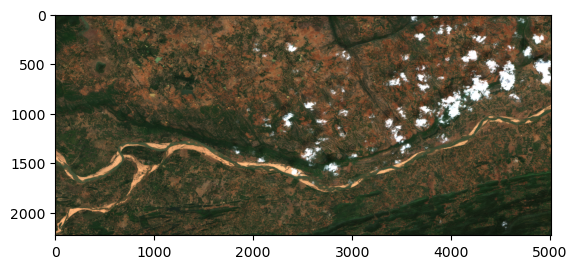

*********************
1 2023-12-18 21:42:39.954568


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


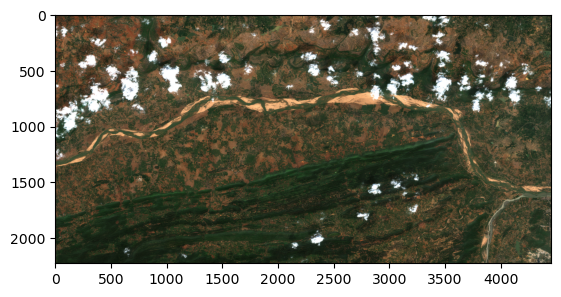

*********************
2 2023-12-18 21:42:42.104965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


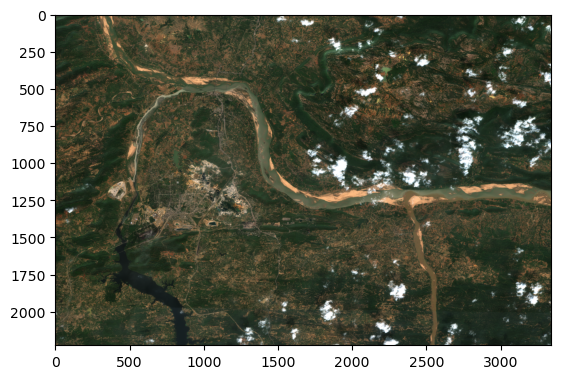

*********************
3 2023-12-18 21:42:43.738320


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


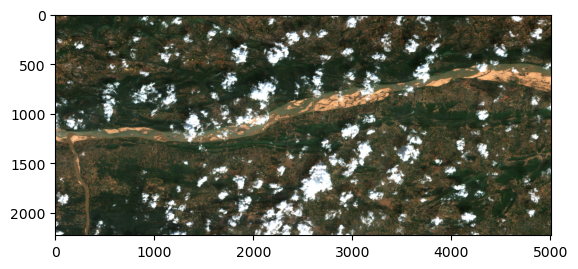

*********************
4 2023-12-18 21:42:46.072301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


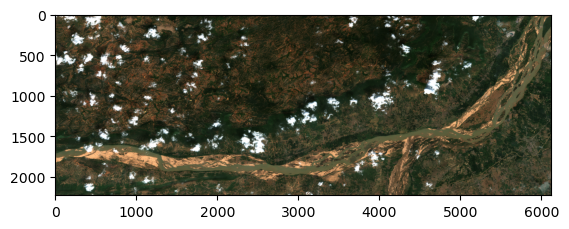

*********************
5 2023-12-18 21:42:49.600099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


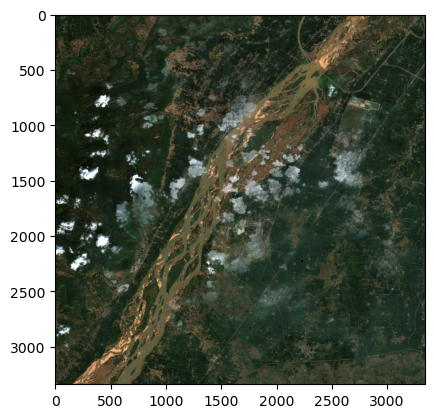

*********************
6 2023-12-18 21:42:52.428726


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


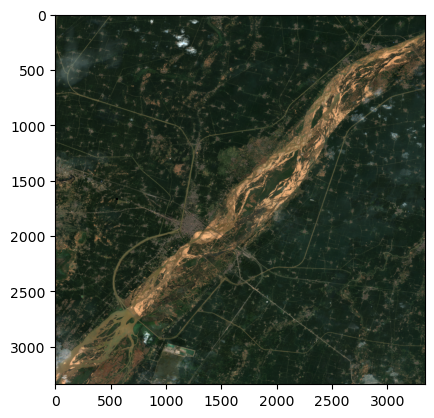

*********************
7 2023-12-18 21:42:55.214966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


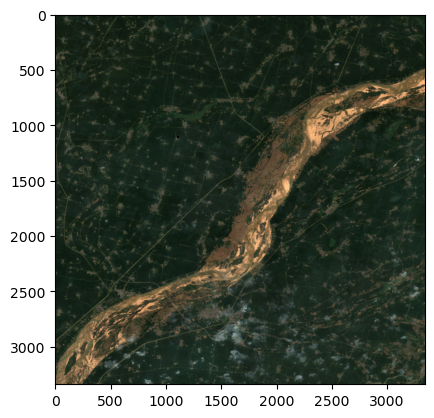

*********************
8 2023-12-18 21:42:58.016536


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


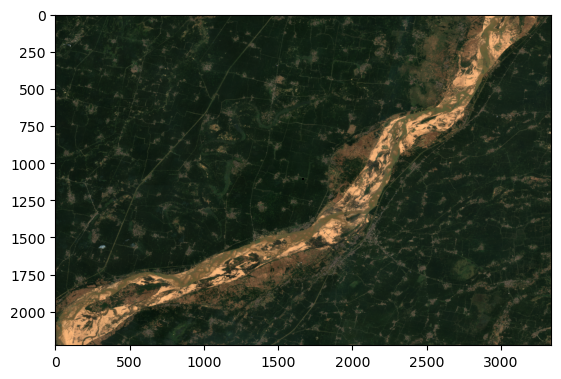

*********************
9 2023-12-18 21:42:59.960458


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


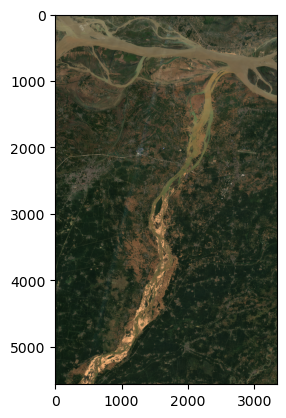

In [211]:

for idval in np.sort(df_tiles['index_right'].unique()):
    print("*********************")
    print(idval, datetime.now())
    filename = f"/data/sand_mining/predictions/raw/Sone_{idval}.tif"
    src = rasterio.open(filename)
    data = src.read([4,3,2])/3500
    show(data)

In [205]:
img_files = glob.glob("/data/sand_mining/predictions/raw/Sone*.tif")
with rasterio.Env():
    print("Reading Files", datetime.now())
    src_files_to_mosaic = [rasterio.open(f) for f in img_files]

    print("Making Mosaic", datetime.now())
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    print("Completed", datetime.now())

#         print("Writing", datetime.now())
#         # Create a new raster file for the merged result
#         with rasterio.open(output_file, 'w', 
#                            driver='GTiff', 
#                            height=mosaic.shape[1], 
#                            width=mosaic.shape[2], 
#                            count=12,
#                            dtype=mosaic.dtype, 
#                            crs=src_files_to_mosaic[0].crs, 
#                            transform=out_trans) as dest:
#             dest.write(mosaic)

Reading Files 2023-12-18 21:32:09.673658
Making Mosaic 2023-12-18 21:32:09.689531
Completed 2023-12-18 21:32:39.785683


In [207]:
print("Writing", datetime.now())
# Create a new raster file for the merged result
with rasterio.open("/data/sand_mining/predictions/intermediate/Sone.tif", 'w', 
                   driver='GTiff', 
                   height=mosaic.shape[1], 
                   width=mosaic.shape[2], 
                   count=12,
                   dtype=mosaic.dtype, 
                   crs=src_files_to_mosaic[0].crs, 
                   transform=out_trans) as dest:
    dest.write(mosaic)

Writing 2023-12-18 21:34:18.226100
